# 1. Naive Bayes for Healthcare
Quick, gentle demo using a Bernoulli Naive Bayes classifier on opioid disorder flags

**Learning objectives**
- See how Naive Bayes models use a prior and conditional feature likelihoods
- Connect the sklearn implementation to Bayes theorem step by step
- Practice using sklearn Pipelines and ColumnTransformer
- Compare with logistic regression and a small decision tree

### 1.1. Naive Bayes in this context

The core idea is to find the probability of a patient having an Opioid Disorder (OD) *given* their features (like 'Surgery' or 'Low_inc').

We want to calculate the **Posterior** probability: $P(OD=1 | \text{Features})$

The theorem gives us a way to calculate this using three pieces of information:

$$P(OD=1 | \text{Features}) \propto P(\text{Features} | OD=1) \times P(OD=1)$$

Breaking this down:

* $P(OD=1 | \text{Features})$
    * **Posterior**: The probability we want. "Given this patient's features, what's the chance they have OD?"
* $P(\text{Features} | OD=1)$
    * **Likelihood**: "Among all patients *who have* OD, how common are these specific features?"
* $P(OD=1)$
    * **Prior**: "What is the overall base rate (or prevalence) of OD in the population, *before* we see any features?"

---

* $P(\text{Features})$ The **Evidence**, is omited, as for classification problems our goal isn't to find the *exact* probability, but to see which class is *more likely*. This denominator (Evidence) is the same constant value for both classes

Therefore, we can ignore it and just compare the numerators:

$$P(\text{Class} | \text{Features}) \propto P(\text{Features} | \text{Class}) \times P(\text{Class})$$
$$(\text{Posterior}) \propto (\text{Likelihood}) \times (\text{Prior})$$

The model calculates this proportional "score" for each class and then predicts the class with the highest score. To get the final probabilities that sum to 1 (like in `predict_proba`), it simply normalizes these scores.

----

### 1.2. Why the "Naive" Assumption

Calculating the **Likelihood** $P(\text{Features} | OD=1)$ is extremely difficult. It requires knowing the probability of *every single combination* of features.

To solve this, we make a "naive" assumption: **we assume all features are independent of each other**, given the class (OD=1 or OD=0).

* This means we *pretend* that having 'Surgery' doesn't make a patient more or less likely to *also* have a 'Low_inc' flag
* This assumption is almost certainly **false** in reality, but it simplifies the math dramatically and works surprisingly well

Because of this assumption, we can just multiply the individual likelihoods:
$P(\text{Features} | OD=1) = P(\text{Surgery} | OD=1) \times P(\text{Low\_inc} | OD=1) \times \dots$

The model "learns" by calculating all these simple probabilities from the training data.

### Why Bernoulli Naive Bayes?

We are using `BernoulliNB` because our features are (or will be treated as) binary (0 or 1, "yes" or "no").
* `BernoulliNB` is designed for binary features
* `GaussianNB` is used for continuous features e.g. prescription

To learn more, refer to [scikit learn 1.9. Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) documentation

# 2. Setup
- We treat most columns as binary flags
- We binarize `rx_ds` as 1 if days supply is greater than 0, else 0
- Target `OD` is 1 for opioid disorder, 0 otherwise

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,   
    precision_recall_curve,    
    auc,                       
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [15]:
DATA_PATH = "Data/opiod_raw_data.csv" # Update with your actual path
df = pd.read_csv(DATA_PATH)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Ensure target is numeric 0 or 1
if df["OD"].dtype == "O":
    mapping = {"yes": 1, "y": 1, "true": 1, "t": 1, "1": 1,
               "no": 0, "n": 0, "false": 0, "f": 0, "0": 0}
    df["OD"] = df["OD"].astype(str).str.lower().map(mapping).astype(float)
df = df.dropna(subset=["OD"]).copy()
df["OD"] = df["OD"].astype(int)

# Drop identifiers
drop_cols = [c for c in ["ID", "Od", "od"] if c in df.columns] + ["OD"]
feature_cols = [c for c in df.columns if c not in drop_cols]

# Columns to binarize
rx_col = "rx_ds" if "rx_ds" in feature_cols else None
binary_passthrough_cols = [c for c in feature_cols if c != rx_col]

transformers = []
if rx_col is not None:
    transformers.append(("bin_rx",
        Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                  ("bin", Binarizer(threshold=0.0))]),
        [rx_col]))
if binary_passthrough_cols:
    transformers.append(("binary", SimpleImputer(strategy="most_frequent"), binary_passthrough_cols))

preprocess = ColumnTransformer(transformers, remainder="drop")

# Define the pipeline
nb_pipe = Pipeline([("prep", preprocess),
                    ("nb", BernoulliNB(alpha=1.0, fit_prior=True))])

# Create data splits <- simple Training/Validation split
X = df[feature_cols].copy()
y = df["OD"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y if y.nunique() > 1 else None
)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Opioid Disorder (OD=1) prevalence in training set: {y_train.mean():.2%}")

Training data shape: (750, 20)
Test data shape: (250, 20)
Opioid Disorder (OD=1) prevalence in training set: 18.13%


# 3. Model Training and Initial Evaluation

Now let's train our Naive Bayes pipeline and see how it performs on the valisation (test) set. We will look at two key metrics for classification:

1.  **ROC AUC (Area Under the Receiver Operating Characteristic Curve)**: A measure of separability
2.  **PR AUC (Area Under the Precision-Recall Curve)**: A better metric when classes are imbalanced (like ours). It shows the trade-off between Precision (being right when you predict OD=1) and Recall (finding all the true OD=1 cases).

--- Naive Bayes Metrics ---
Ranking Metrics (Threshold-Independent):
  ROC AUC: 0.711
  PR AUC: 0.353

Threshold-Based Metrics (at 0.5 default threshold):
  Precision: 0.310
  Recall: 0.200

--- Confusion Matrix ---


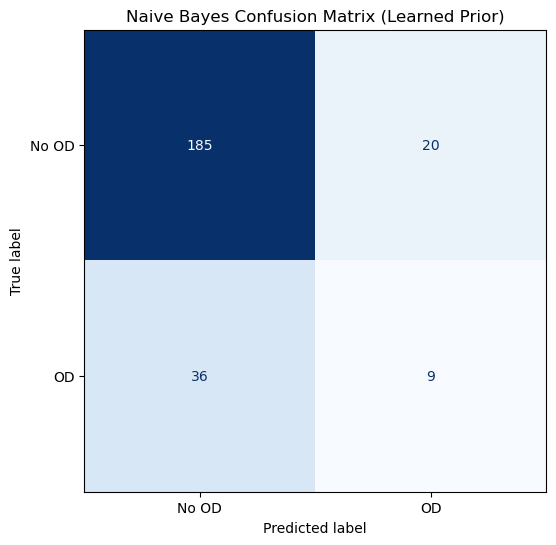

In [16]:
# --- Train the Model ---
nb_pipe.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = nb_pipe.predict(X_test)
y_proba = nb_pipe.predict_proba(X_test)[:, 1]

# --- Calculate Metrics (Directly) ---
pr_auc = average_precision_score(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
# --- NEW: Calculate Precision and Recall ---
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("--- Naive Bayes Metrics ---")
print("Ranking Metrics (Threshold-Independent):")
print(f"  ROC AUC: {auc:.3f}")
print(f"  PR AUC: {pr_auc:.3f}")
print("\nThreshold-Based Metrics (at 0.5 default threshold):")
print(f"  Precision: {precision:.3f}")
print(f"  Recall: {recall:.3f}")

# --- Plot the Confusion Matrix (Directly) ---
print("\n--- Confusion Matrix ---")
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        ax=ax,
                                        cmap='Blues',
                                        colorbar=False,
                                        display_labels=["No OD", "OD"])
ax.set_title("Naive Bayes Confusion Matrix (Learned Prior)")
plt.show()

## 3.1. Where does the prior $P(Y)$ come from?

This is the first part of the Bayes formula: $P(OD=1)$. It's our "starting belief" about the probability of Opioid Disorder *before* we look at any features.

By default (`fit_prior=True`), **`sklearn` learns the prior from the class balance in the training data**.

* If 10% of patients in `y_train` have `OD=1`, the model will set $P(OD=1) = 0.1$ and $P(OD=0) = 0.9$

However, we can also **manually set the prior**, making this a powerful Bayesian feature.
* You might do this if you *know* the true prevalence in the wider population is different from your sample
* For example, let's say we have external knowledge that the true prevalence of OD in the general population is **5%**
* We can force the model to use this external belief instead of the one learned from our (potentially biased) sample data

Let's inspect the prior `sklearn` learned from the data and compare its performance to a model where we manually set the prior to 5% ($P(OD=1)=0.05$).

In [17]:
nb_model = nb_pipe.named_steps["nb"]
priors_learned = np.exp(nb_model.class_log_prior_)
print(f"Learned class prior P(OD=0): {priors_learned[0]:.4f}")
print(f"Learned class prior P(OD=1): {priors_learned[1]:.4f}")
print(f"(Note: This should match the {y_train.mean():.2%} prevalence from the training data)")

# Create a new model forcing an external 5% prior
# P(OD=0) = 0.95, P(OD=1) = 0.05
nb_external_prior = Pipeline([("prep", preprocess),
                              ("nb", BernoulliNB(alpha=1.0, fit_prior=False, class_prior=[0.95, 0.05]))])
nb_external_prior.fit(X_train, y_train)
ext_proba = nb_external_prior.predict_proba(X_test)[:, 1]
# --- NEW: Get 0/1 predictions for the external prior model ---
ext_pred = nb_external_prior.predict(X_test)

print("\n--- Ranking Metrics Comparison (Unaffected by Prior) ---")
print(f"ROC AUC with learned prior:   {roc_auc_score(y_test, y_proba):.3f}")
print(f"ROC AUC with external 5% prior: {roc_auc_score(y_test, ext_proba):.3f}")
print(f"\nPR AUC with learned prior:    {average_precision_score(y_test, y_proba):.3f}")
print(f"PR AUC with external 5% prior:  {average_precision_score(y_test, ext_proba):.3f}")

# --- NEW SECTION ---
print("\n--- Threshold-Based Metrics Comparison (Affected by Prior) ---")
# Metrics for learned prior model (using y_pred from previous cell)
precision_learned = precision_score(y_test, y_pred)
recall_learned = recall_score(y_test, y_pred)
# Metrics for external 5% prior model
precision_external = precision_score(y_test, ext_pred)
recall_external = recall_score(y_test, ext_pred)

print(f"\nPrecision (at 0.5 threshold):")
print(f"  Learned prior (18.1%):   {precision_learned:.3f}")
print(f"  External 5% prior: {precision_external:.3f}")

print(f"\nRecall (at 0.5 threshold):")
print(f"  Learned prior (18.1%):   {recall_learned:.3f}")
print(f"  External 5% prior: {recall_external:.3f}")

Learned class prior P(OD=0): 0.8187
Learned class prior P(OD=1): 0.1813
(Note: This should match the 18.13% prevalence from the training data)

--- Ranking Metrics Comparison (Unaffected by Prior) ---
ROC AUC with learned prior:   0.711
ROC AUC with external 5% prior: 0.711

PR AUC with learned prior:    0.353
PR AUC with external 5% prior:  0.353

--- Threshold-Based Metrics Comparison (Affected by Prior) ---

Precision (at 0.5 threshold):
  Learned prior (18.1%):   0.310
  External 5% prior: 0.000

Recall (at 0.5 threshold):
  Learned prior (18.1%):   0.200
  External 5% prior: 0.000


### **So, what happend?**

#### 1. Ranking Metrics (ROC AUC / PR AUC)

* **Result:** These scores arethe same for both models
* **Why?** These metrics (ROC AUC and Average Precision) are **ranking metrics**. They only measure how well the model *sorts* the patients. They check if the model consistently gives higher probability scores to `OD=1` patients than to `OD=0` patients
* **What happened:** Changing the prior from 18.1% to 5% *lowered* everyone's final probability score, but it **did not change their order**. The patient who was ranked #1 highest risk is still #1, and #2 is still #2. Since the ranking is identical, the AUC scores are identical

#### 2. Threshold-Based Metrics (Precision & Recall)

* **Result:** These scores **changed dramatically**, dropping to **0.0!!**
* **Why?** These metrics first apply a fixed **0.5 probability threshold** to make a final "Yes" (`OD=1`) or "No" (`OD=0`) decision
* **Learned Prior (18.1%):** The model's probabilities were high enough that some patients crossed the 0.5 threshold. For those "Yes" predictions, the model was 31.0% precise and found 20.0% of all true cases (Recall)
* **External 5% Prior (The Key Insight):** When we forced the prior down to 5%, we told the model that `OD=1` is actually *extremely rare* in the general population. This adjustment lowered *all* the final probability scores so much that **not a single patient's score crossed the 0.5 threshold**
* **Why 0.0?** Since the model predicted "No" for everyone, it found **0** True Positives.
    * **Recall is 0.0** because it found 0 out of the 45 positive patients
    * **Precision is 0.0** because it didn't make *any* positive predictions at all (the denominator is zero, which `sklearn` reports as 0.0)

**Key Takeaway:** By changing the prior, we changed its **calibration**. It has now become extremely "conservative," and at the default 0.5 threshold, it r"efuses" to label anyone as high-risk

## 3.2. Do we gain any interpretability vs. other models?

This is a major strength of Naive Bayes. The model is not a "black box" at all. Its internal logic is fully transparent.

1.  **Global Interpretability (The Model's "Brain")**: We can directly inspect the *learned likelihoods* $P(\text{Feature}=1 | \text{Class})$. This tells us *what the model learned* about the two groups (OD=1 vs OD=0). We can see which features are most associated with each class.

2.  **Local Interpretability (Per-Patient)**: Because the model is additive in log-space, we can see *exactly* how much each of a patient's features contributed to their final score.

Let's start with the **global** view by extracting the learned likelihoods from the model.

In [27]:
# --- Global Model Interpretability (External 5% Prior Model) ---

# 1. Get the Naive Bayes model object from the second pipeline
ext_model = nb_external_prior.named_steps["nb"]

# 2. Get feature names from the preprocessing step
feat_names = nb_external_prior.named_steps["prep"].get_feature_names_out()

# 3. Get the feature log probabilities (This is learned from X and y, ignores the prior)
flog_ext = ext_model.feature_log_prob_
p1_ext = np.exp(flog_ext[1, :])  # P(x=1 | OD=1)
p0_ext = np.exp(flog_ext[0, :])  # P(x=1 | OD=0)
eps = 1e-9 # Epsilon to avoid log(0)

# 4. Build the table
ratio_ext = (p1_ext + eps) / (p0_ext + eps)
logit_diff_ext = np.log((p1_ext + eps) / (1 - p1_ext + eps)) - np.log((p0_ext + eps) / (1 - p0_ext + eps))
rank_tbl_ext = pd.DataFrame({
    "feature": feat_names,
    "P(x=1|OD=1)": p1_ext,
    "P(x=1|OD=0)": p0_ext,
    "ratio_p1_over_p0": ratio_ext,
    "logit_diff": logit_diff_ext
}).sort_values("logit_diff", ascending=False)

print("--- Global Model Interpretability (External 5% Prior Model) ---")
display(rank_tbl_ext.head(10).style)

--- Global Model Interpretability (External 5% Prior Model) ---


,feature,P(x=1|OD=1),P(x=1|OD=0),ratio_p1_over_p0,logit_diff
1,binary__Low_inc,0.608696,0.237013,2.568195,1.610959
19,binary__V,0.094203,0.056818,1.657971,0.546038
0,bin_rx__rx_ds,0.789855,0.727273,1.086051,0.343223
8,binary__F,0.565217,0.521104,1.084654,0.177898
7,binary__E,0.608696,0.571429,1.065217,0.154151
2,binary__SURG,0.442029,0.407468,1.084820,0.141513
11,binary__J,0.521739,0.501623,1.040101,0.080518
15,binary__N,0.471014,0.451299,1.043687,0.079353
3,binary__A,0.362319,0.352273,1.028518,0.043750
12,binary__K,0.528986,0.527597,1.002631,0.005570


### Interpreting the Feature Likelihood Table

The table above is the *core* of the model.
* **P(x=1|OD=1)**: The probability a patient *with* Opioid Disorder has this feature. e.g. P(binary__F=1 | OD=1) is the probability that a patient *with* OD also has a mental health flag (F)
* **P(x=1|OD=0)**: The probability a patient *without* Opioid Disorder has this feature
* **logit_diff**: This is our best metric for feature importance (log-odds ratio)
    * A large **positive** value means this feature is a **strong signal for OD=1**

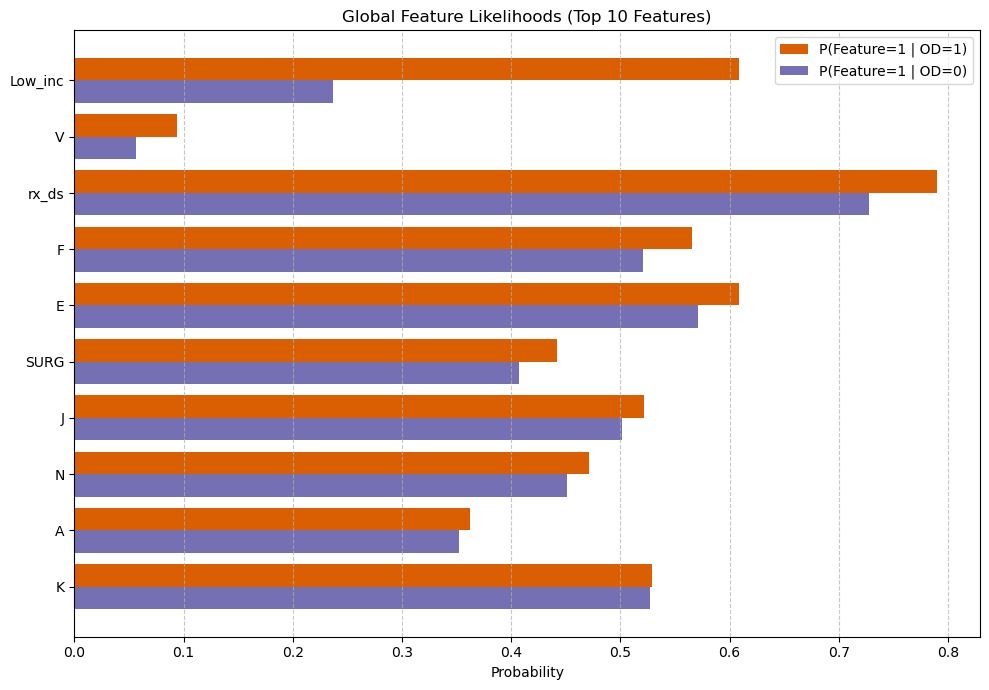

In [30]:

# --- Global Interpretability Visualization ---
# Assumes 'rank_tbl_ext' exists from the previous Q3 cell

# Get the Top 10 most important features (by logit_diff)
top_features_df = rank_tbl_ext.sort_values("logit_diff", ascending=False).head(10)
top_features_df = top_features_df.iloc[::-1] # Reverse for plotting (highest on top)

# Get labels and values
labels = [name.replace("binary__", "").replace("bin_rx__", "") for name in top_features_df["feature"]]
p_od_1 = top_features_df["P(x=1|OD=1)"]
p_od_0 = top_features_df["P(x=1|OD=0)"]

y = np.arange(len(labels))  # the label locations
height = 0.4  # the height of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.barh(y + height/2, p_od_1, height, label='P(Feature=1 | OD=1)', color='#d95f02')
rects2 = ax.barh(y - height/2, p_od_0, height, label='P(Feature=1 | OD=0)', color='#7570b3')

# Add some text for labels, title and axes ticks
ax.set_xlabel('Probability')
ax.set_title('Global Feature Likelihoods (Top 10 Features)')
ax.set_yticks(y)
ax.set_yticklabels(labels)
ax.legend()
ax.grid(axis='x', linestyle='--', alpha=0.7)

fig.tight_layout()
plt.show()

### Interpreting a Single Prediction (Local Interpretability)

Now for the **local** view. We can see *why* a single patient got their prediction. The code below breaks down the score for the *first patient in the test set*

In [29]:
# --- Local Interpretability (External 5% Prior Model) for Test Patient 0 ---

# --- Recalculate all necessary variables ---
# 1. Get the model object
ext_model = nb_external_prior.named_steps["nb"]

# 2. Get the preprocessed test data and feature names
Xt = nb_external_prior.named_steps["prep"].transform(X_test)
feat_names = nb_external_prior.named_steps["prep"].get_feature_names_out()

# 3. Get the first patient's data
x0 = Xt[0, :].astype(int)

# 4. Get the learned feature log-likelihoods (P(X|Y))
flog_ext = ext_model.feature_log_prob_
p1_ext = np.exp(flog_ext[1, :])  # P(x=1 | OD=1)
p0_ext = np.exp(flog_ext[0, :])  # P(x=1 | OD=0)
eps = 1e-9

# 5. Calculate the "contribution" of each feature for Patient 0
# This is log( P(x|y=1) / P(x|y=0) ) for this patient's x values
contrib_ext = x0 * (np.log(p1_ext + eps) - np.log(p0_ext + eps)) + \
              (1 - x0) * (np.log(1 - p1_ext + eps) - np.log(1 - p0_ext + eps))

# 6. Get the intercept (base score) from the model's 5% prior
# This is log( P(y=1) / P(y=0) )
ext_intercept = ext_model.class_log_prior_[1] - ext_model.class_log_prior_[0]

# 7. Calculate the final total score
# (Base Score from Prior) + (Sum of all Feature Scores)
ext_llr_total = ext_intercept + contrib_ext.sum()
# --- End of recalculation ---


# 8. Build the explanation table
manual_tbl_ext = pd.DataFrame({
    "feature": feat_names,
    "x_value_after_binarize": x0,
    "contribution_to_log_likelihood_ratio": contrib_ext
}).sort_values("contribution_to_log_likelihood_ratio", ascending=False)

print(f"\n--- Local Interpretability (External 5% Prior Model) for Test Patient 0 ---")
print(f"Base Log-Odds (from 5% Prior): {ext_intercept:.4f}")
print(f"Sum of Feature Contributions: {contrib_ext.sum():.4f}")
print(f"Total Log-Odds: {ext_llr_total:.4f}")
print("\nTop Feature Contributions (positive = moves toward OD=1):")
display(manual_tbl_ext.head(10).style)


--- Local Interpretability (External 5% Prior Model) for Test Patient 0 ---
Base Log-Odds (from 5% Prior): -2.9444
Sum of Feature Contributions: 1.4312
Total Log-Odds: -1.5132

Top Feature Contributions (positive = moves toward OD=1):


,feature,x_value_after_binarize,contribution_to_log_likelihood_ratio
1,binary__Low_inc,1,0.943203
16,binary__R,0,0.715835
18,binary__T,0,0.157430
9,binary__H,0,0.148581
13,binary__L,0,0.125447
0,bin_rx__rx_ds,1,0.082548
6,binary__D,0,0.055974
10,binary__I,0,0.054783
5,binary__C,0,0.044726
12,binary__K,1,0.002628


This output shows the model's step-by-step "reasoning" for a single person, "Test Patient 0." It shows exactly how the model went from its starting assumption (the 5% prior) to its final prediction for this one patient.

#### The Final Calculation

* **Base Log-Odds (from 5% Prior):**
    * This is the **Starting Score**.
    * It comes *only* from the **external 5% prior**. Since 5% is extremely rare, the starting score is a large negative number. This means the model is **highly biased** to assume this patient is `OD=0` **before it even looks at their features.**

* **Sum of Feature Contributions:**
    * This is the **Total Evidence Score** from the patient's data
    * The patient's personal data, on its own, points towards `OD=1` with a postive score

* **Total Log-Odds:**
    * This is the **Final Score**: `(Starting Score) + (Total Evidence Score)` (Log-Odds + Feat. Contribution)
    * Even though the patient's features positive, the model's strong initial "conservative" bias (from the 5% prior) regresses it towards the prevalence
    * The final score is still negative, so the model confidently predicts `OD=0`. This is *why* the Precision and Recall for this model dropped to 0.0 at the 0.5 threshold


#### The Evidence Table

This table shows *which* features provided the **Feature Contribution evidence score** (w/ o effect from the prior)

* **x_value_after_binarize**: Is Patient 0's actual data (`1` = they have it, `0` = they don't)
* **contribution_to_log..**: These are the "points" added to the score for that feature

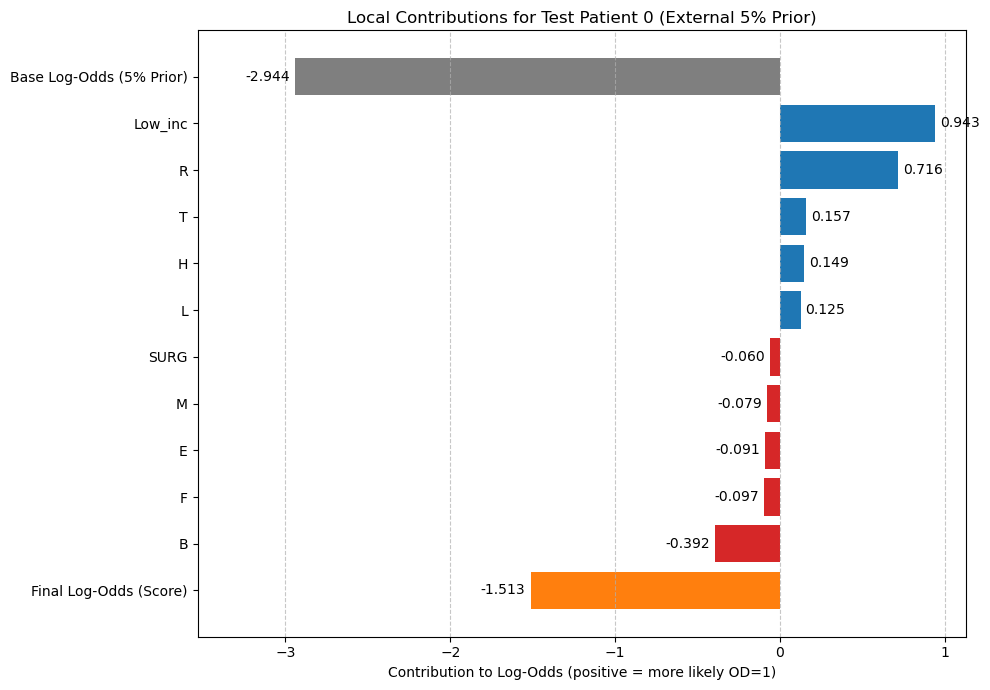

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Local Interpretability Visualization (Patient 0) ---
# Assumes 'manual_tbl_ext', 'ext_intercept', and 'ext_llr_total' exist

# Get top 5 positive and top 5 negative contributors
top_contributors = pd.concat([
    manual_tbl_ext.head(5),
    manual_tbl_ext.tail(5)
]).sort_values("contribution_to_log_likelihood_ratio", ascending=False)

# Add the Base Prior and Final Score
plot_data = pd.DataFrame({
    "contribution": np.concatenate([
        [ext_intercept],
        top_contributors["contribution_to_log_likelihood_ratio"],
        [ext_llr_total]
    ])
}, index=np.concatenate([
        ["Base Log-Odds (5% Prior)"],
        [name.replace("binary__", "").replace("bin_rx__", "") for name in top_contributors["feature"]],
        ["Final Log-Odds (Score)"]
    ])
)

plot_data = plot_data.iloc[::-1] # Reverse for plotting

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#1f77b4' if c > 0 else '#d62728' for c in plot_data["contribution"]]
colors[0] = '#ff7f0e' # Final score
colors[-1] = '#7f7f7f' # Base score

ax.barh(plot_data.index, plot_data["contribution"], color=colors)
ax.set_xlabel("Contribution to Log-Odds (positive = more likely OD=1)")
ax.set_title("Local Contributions for Test Patient 0 (External 5% Prior)")
ax.grid(axis='x', linestyle='--', alpha=0.7)

# --- IMPROVED TEXT LABELS ---
# Add value labels outside the bars
for i, v in enumerate(plot_data["contribution"]):
    padding = 0.03
    if v > 0:
        # For positive bars, place text to the right
        ax.text(v + padding, i, f"{v:.3f}", color='black', ha='left', va='center')
    else:
        # For negative bars, place text to the left
        ax.text(v - padding, i, f"{v:.3f}", color='black', ha='right', va='center')

# Adjust x-limits to make space for the text
min_val = plot_data["contribution"].min()
max_val = plot_data["contribution"].max()
ax.set_xlim(min_val * 1.2, max_val * 1.2) # Add 20% padding

fig.tight_layout()
plt.show()